# Test Error, Cross-Validation, and Model Selection


Exploring cross-validation and model selection using data collected regarding features describing a set of soccer players. The target variable is the "overall" score on each of the players' overall performance.

In [1]:
#import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin

pd.set_option('display.max_columns', 500)

%matplotlib inline

In [2]:
#clean up the data by removing irrelevant columns and converting appropriate variables to dummies
df=pd.read_csv("footballer_data.csv")
toBeDropped=['ID','club','club_logo','birth_date','flag','nationality','photo','potential']
toBeDummied=["work_rate_att","work_rate_def","preferred_foot"]
df=df.drop(toBeDropped, axis='columns')
df=pd.get_dummies(df,columns=toBeDummied, drop_first=True)
display(df.head())

,age,height_cm,weight_kg,overall,pac,sho,pas,dri,def,phy,international_reputation,skill_moves,weak_foot,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,work_rate_att_Low,work_rate_att_Medium,work_rate_def_Low,work_rate_def_Medium,preferred_foot_Right
0,32,185.0,80.0,94,90,93,82,90,33,80,5,5,4,85,94,88,83,88,91,81,76,77,93,89,91,89,96,63,94,95,92,80,92,63,29,95,85,85,95,22,31,0,0,1,0,1
1,30,170.0,72.0,93,89,90,86,96,26,61,5,4,4,77,95,71,88,85,97,89,90,87,95,92,87,90,95,95,85,68,73,59,88,48,22,93,90,78,96,13,28,0,1,0,1,0
2,25,175.0,68.0,92,92,84,79,95,30,60,5,5,5,75,89,62,81,83,96,81,84,75,95,94,90,96,88,82,80,61,78,53,77,56,36,90,80,81,92,21,24,0,0,0,1,1
3,30,182.0,86.0,92,82,90,79,87,42,81,5,4,4,77,94,77,83,88,86,86,84,64,91,88,77,86,93,60,87,69,89,80,86,78,41,92,84,85,83,30,45,0,0,0,1,1
4,31,193.0,92.0,92,91,90,95,89,60,91,5,1,4,15,13,25,55,11,30,14,11,59,48,58,61,52,85,35,25,78,44,83,16,29,30,12,70,47,70,10,10,0,1,0,1,1


In [3]:
#define a function which computes the mean absolute error
def mse(y, ypred):
    mse=np.mean(np.square(y-ypred))
    return mse


48.25436033850663 48.257042179241274


/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


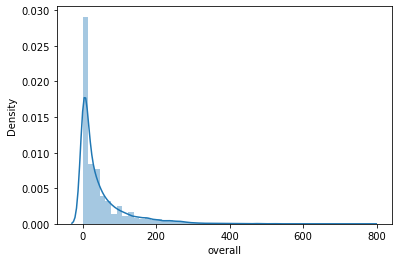

In [4]:
#compute the baseline accuracy for models to be explored if the "overall" variable was to be used 
import math
mean_squared_error=mse(df.overall,np.mean(df.overall))
squared_losses=np.square(np.subtract(df.overall, np.mean(df.overall)))
std= np.divide(np.sum(squared_losses), len(df)-1)

print(mean_squared_error, std)

# Plot distribution  
sns.distplot(squared_losses)
plt.show()



In [6]:
#split the data into training and testing sets
#calculate the precision which would result from a 50/50 split

#let n=17994/2=8997
d=((1.96*std)/math.sqrt(8997))
print(d) ## this is the precision that splitting the test/training set 50/50 will acheive

0.9971670290275789


In [7]:
#create a pipeline for a linear regression model
model1=Pipeline([('linear_regression', LinearRegression())])

In [9]:
#perform 5-fold cross-validation using the pipeline created above, using the mean square error as the cross-validation scoring function
X=df.drop("overall", axis="columns")
y=df.overall
sc=make_scorer(mse)
cv_scores=cross_val_score(model1, X, y, cv=5, scoring=sc)
print(cv_scores.mean()) # report the cross-validation score

8.981956750632694


In [10]:
#explore how introducing a quadratic age term in the data set will effect the performance of the model
class Age2(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X=X.assign(age2=X.age**2)
        return X
    
model2=Pipeline([('age2',Age2()),("linear_regression",LinearRegression())])

cv_scores=cross_val_score(model2, X,y, cv=5, scoring=sc)
print(cv_scores.mean())

8.485229823844055


Observation: The introduction of the quadratic age term slightly improved the performance of the model.

In [11]:
#explore the addition of polynomial features to the data set on the performance of the model
model3=Pipeline([('poly',PolynomialFeatures(degree=2, include_bias=False)),('linear_regression',LinearRegression())])
cv_scores=cross_val_score(model3, X, y, cv=5, scoring=sc)
print(cv_scores.mean())

2.199385134289178


The introduction of second-order polynomial features significantly improved the performance of the model! Adding third-order interactions will likely be a bad idea however,as adding too much complexity to the model causes a decrease in training error but a subsequent increase in testing error. This is due to the bias-variance tradeoff: as you increase model complexity, the model bias decreases but the model variance increases. This would be an example of overfitting our model so that it performs very well on a training set, but increasingly worse on a given test set.

1.4452414306115893 [-11.956164327087407, 14.846647188310587]


/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


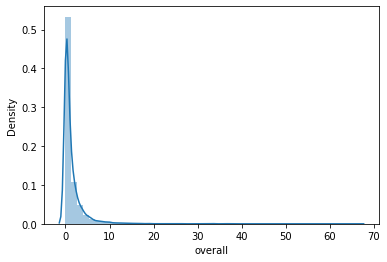

In [12]:
#now compute a point estimate on the generalization error and a corresponding 95% confidence interval
#use the model including second-order interactions, as this has the lowest cross-validation error of all models explored
#start by splitting up the data
xtrain, xtest, ytrain, ytest= train_test_split(X, y, test_size=0.5, random_state=0)
model3.fit(xtrain, ytrain)
ypred=model3.predict(xtest)
gen_err=mse(ypred, ytest) #here is the generalization error (the point estimate)
from scipy.stats import t
n=len(ypred)
t_val=t.ppf(1-0.05/2, df=n-1)
std=ypred.std(ddof=1)
upper=gen_err+t_val*std
lower=gen_err-t_val*std
bounds=[lower, upper]

print(gen_err, bounds)

#compute the squared errors for plotting
squared_errors=np.square(np.subtract(ypred, ytest))
sns.distplot(squared_errors)
plt.show()